## Train and Prediction on all data

Using rotated to hz + OpenCv border

Basic default transforms

Padded BG data

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
import geopandas as gpd
from resizeimage import resizeimage
import datetime
import uuid
from os import listdir
from os.path import isfile, join

In [3]:
torch.cuda.set_device(1)
torch.cuda.current_device()

1

In [4]:
data_dir = Path('data_02')
data_orig = Path('data')

In [5]:
RETRAIN = True
RESIZE_IMAGES = True

In [6]:
MODEL_NAME='cv_reflect_101_valid'

In [7]:
NB_NUM='03_26'

In [8]:
DATE = datetime.datetime.today().strftime('%Y%m%d')
UID=str(uuid.uuid4())[:8]
print(f'UID: {UID}, DATE: {DATE}')                                                 

UID: ce19e9a8, DATE: 20191130


In [9]:
#DATE = '20191118'
#UID = 'a18f1438'

In [10]:
SUB_NUM='30'

In [11]:
#wrap or reflect
border='reflect'
#padded or padded_bg
pad_type='padded'
img_size=256
bs=128

In [12]:
train_images=data_dir/f'train/rotated/clipped/{pad_type}/{border}/{img_size}'
test_images=data_dir/f'test/rotated/clipped/{pad_type}/{border}/{img_size}'

In [13]:
test_names = get_image_files(test_images)

In [14]:
len(test_names)

14650

In [15]:
df_all=pd.read_csv(data_dir/'df_train_all.csv')

In [16]:
len(df_all)

22553

### using valid + gold preds instead of all

In [17]:
df_gold=pd.read_csv(data_orig/'df_all_repl_st_lucia_castries_gold_concrete_cement.csv')

In [18]:
df_gold.drop(columns=['target'],inplace=True)

In [19]:
df_gold=df_gold[['id','roof_material','verified','country','region']]

In [20]:
df_pewter_70pct=pd.read_csv(data_orig/'st_lucia_castries_gros_islet_70pct_rn50-rn152-dn121_preds.csv')

In [21]:
frames = [df_gold, df_pewter_70pct]

df_gold_pewter = pd.concat(frames)

In [22]:
#### test

In [23]:
df_test=pd.read_csv(data_dir/'df_test_all.csv')

In [24]:
df_test.tail()

,id,country,region
7320,7a4f3ff4,st_lucia,dennery
7321,7a4fc578,st_lucia,dennery
7322,7a4ac7b2,st_lucia,dennery
7323,7a47e25e,st_lucia,dennery
7324,7a4e3f78,st_lucia,dennery


In [25]:
assert len(df_test)==7325

To put this in a `DataBunch` while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using `ImageList` (and not `ImageDataBunch`). This will make sure the model created has the proper loss function to deal with the multiple classes.

In [26]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

### setup dataset

In [27]:
np.random.seed(42)
dep_var='roof_material'
src = (ImageList.from_df(path=train_images, df=df_gold_pewter, cols='id', suffix='.tif')
       .split_by_rand_pct(0.2)
      .label_from_df(cols=dep_var)
      .add_test_folder(test_images))

25908


In [28]:
data = (src.transform(tfms, size=img_size)
        .databunch(bs=bs).normalize(imagenet_stats))

In [29]:
#to check what params object has
#dir(data)

In [30]:
data.label_list

LabelLists;

Train: LabelList (20727 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data_02/train/rotated/clipped/padded/reflect/256;

Valid: LabelList (5181 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
healthy_metal,healthy_metal,healthy_metal,healthy_metal,irregular_metal
Path: data_02/train/rotated/clipped/padded/reflect/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data_02/train/rotated/clipped/padded/reflect/256

In [31]:
data.loss_func

FlattenedLoss of CrossEntropyLoss()

`show_batch` still works, and show us the different labels separated by `;`.

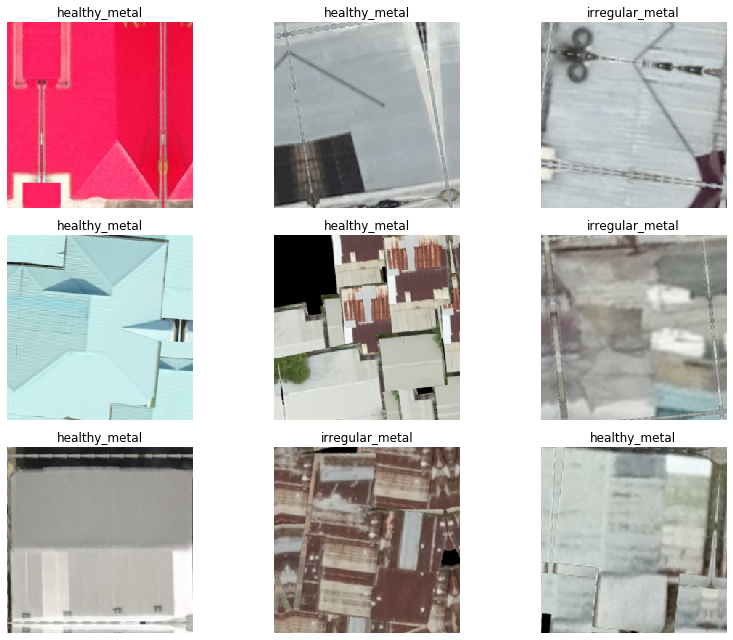

In [32]:
data.show_batch(rows=3, figsize=(12,9))

### Model

In [33]:
arch = models.resnet50
arch_name = 'rn50'

In [34]:
learn = cnn_learner(data, arch, metrics=error_rate, bn_final=True).to_fp16()

We use the LR Finder to pick a good learning rate.

### Train model

In [35]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


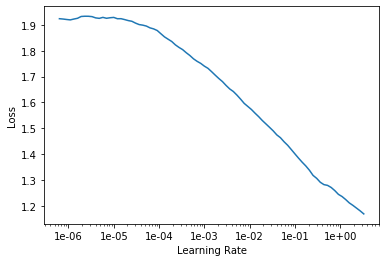

In [36]:
learn.recorder.plot()

Then we can fit the head of our network.

In [37]:
lr = 2e-3

In [38]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,1.115200,0.873664,0.202857,00:58
1,0.799609,0.688511,0.158078,00:57
2,0.620450,0.562579,0.139355,00:58
3,0.544105,0.515847,0.130091,00:57
4,0.508466,0.510957,0.132986,00:59


In [39]:
print(f'stage-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

stage-1-rn50-03_26-cv_reflect_101_valid-20191130-ce19e9a8


In [40]:
learn.save(f'stage-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

In [41]:
learn.load(f'stage-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

Learner(data=ImageDataBunch;

Train: LabelList (20727 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data_02/train/rotated/clipped/padded/reflect/256;

Valid: LabelList (5181 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
healthy_metal,healthy_metal,healthy_metal,healthy_metal,irregular_metal
Path: data_02/train/rotated/clipped/padded/reflect/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data_02/train/rotated/clipped/padded/reflect/256, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, st

In [42]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,0.502232,0.491148,0.136074,00:57
1,0.460193,0.422878,0.126809,00:56
2,0.413451,0.391616,0.124493,00:59
3,0.380134,0.381718,0.126230,00:57
4,0.349907,0.378684,0.123335,00:59


In [43]:
learn.save(f'stage-1-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

#### Load model

In [44]:
learn.load(f'stage-1-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

Learner(data=ImageDataBunch;

Train: LabelList (20727 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data_02/train/rotated/clipped/padded/reflect/256;

Valid: LabelList (5181 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
healthy_metal,healthy_metal,healthy_metal,healthy_metal,irregular_metal
Path: data_02/train/rotated/clipped/padded/reflect/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data_02/train/rotated/clipped/padded/reflect/256, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, st

In [45]:
interp = ClassificationInterpretation.from_learner(learn)
interp.most_confused(min_val=2)

[('irregular_metal', 'healthy_metal', 259),
 ('healthy_metal', 'irregular_metal', 120),
 ('incomplete', 'irregular_metal', 59),
 ('other', 'healthy_metal', 43),
 ('concrete_cement', 'healthy_metal', 27),
 ('healthy_metal', 'concrete_cement', 27),
 ('incomplete', 'healthy_metal', 21),
 ('irregular_metal', 'concrete_cement', 21),
 ('incomplete', 'concrete_cement', 16),
 ('concrete_cement', 'irregular_metal', 12),
 ('concrete_cement', 'incomplete', 10),
 ('irregular_metal', 'incomplete', 7),
 ('other', 'irregular_metal', 7),
 ('healthy_metal', 'incomplete', 5),
 ('healthy_metal', 'other', 3),
 ('irregular_metal', 'other', 2)]

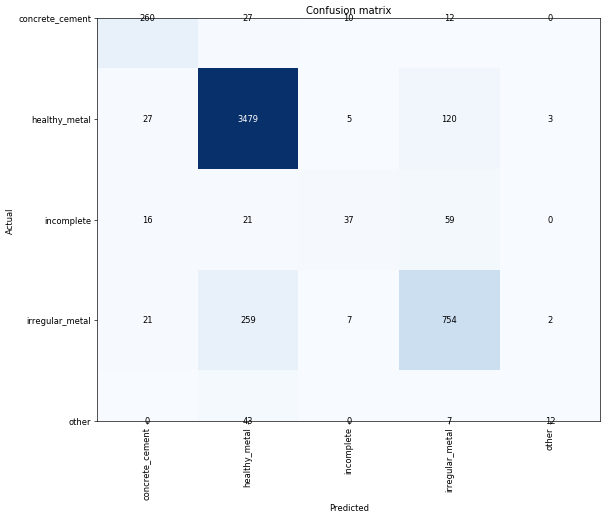

In [46]:
interp.plot_confusion_matrix(figsize=(10,10), dpi=60)

### Re-train

In [47]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


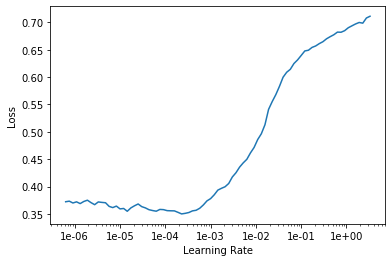

In [48]:
learn.lr_find()
learn.recorder.plot()

In [49]:
learn.fit_one_cycle(5, slice(2e-6, lr/5))

epoch,train_loss,valid_loss,error_rate,time
0,0.360918,0.373226,0.120633,01:13
1,0.358579,0.362300,0.121791,01:14
2,0.327825,0.360706,0.118124,01:15
3,0.296380,0.355626,0.118124,01:14
4,0.283159,0.355528,0.117545,01:14


In [50]:
learn.save(f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

In [51]:
learn.load(f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

Learner(data=ImageDataBunch;

Train: LabelList (20727 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data_02/train/rotated/clipped/padded/reflect/256;

Valid: LabelList (5181 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
healthy_metal,healthy_metal,healthy_metal,healthy_metal,irregular_metal
Path: data_02/train/rotated/clipped/padded/reflect/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data_02/train/rotated/clipped/padded/reflect/256, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, st

In [52]:
#learn.fit_one_cycle(5, slice(5e-7, lr/5))

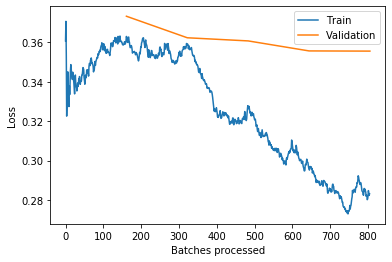

In [53]:
learn.recorder.plot_losses()

In [54]:
#learn.save(f'stage-2-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

In [55]:
#learn.load(f'stage-2-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

### Larger size images

In [56]:
train_images=data_dir/f'train/rotated/clipped/{pad_type}/{border}/512'
test_images=data_dir/f'test/rotated/clipped/{pad_type}/{border}/512'

In [57]:
np.random.seed(42)
dep_var='roof_material'
src = (ImageList.from_df(path=train_images, df=df_gold_pewter, cols='id', suffix='.tif')
       .split_by_rand_pct(0.2)
      .label_from_df(cols=dep_var)
      .add_test_folder(test_images))

25908


In [58]:
data = (src.transform(tfms, size=512)
        .databunch(bs=16).normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 512, 512])

In [59]:
learn=learn.to_fp16()

In [60]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


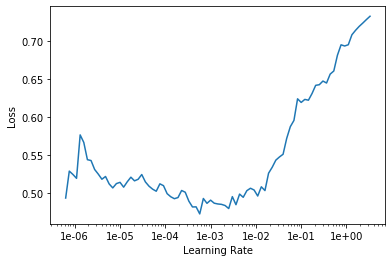

In [61]:
learn.lr_find()
learn.recorder.plot()

In [62]:
lr=1e-4

In [63]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,0.454910,0.386353,0.129512,04:27
1,0.423967,0.374266,0.121791,04:28
2,0.422609,0.369374,0.121598,04:28
3,0.443641,0.366425,0.123528,04:29
4,0.424183,0.368635,0.116966,04:26


In [64]:
learn.save(f'stage-1-512-{arch_name}-{MODEL_NAME}-{DATE}-{UID}')

In [65]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


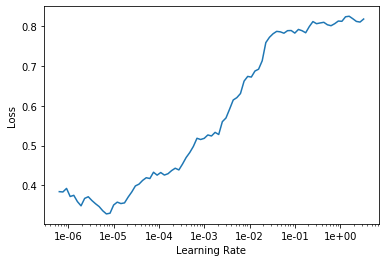

In [66]:
learn.lr_find()
learn.recorder.plot()

In [67]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,error_rate,time
0,0.423405,0.360372,0.117159,05:48
1,0.445263,0.372496,0.120633,05:48
2,0.431293,0.367784,0.124879,05:50
3,0.384171,0.362771,0.124493,05:46
4,0.388461,0.359579,0.118124,05:46


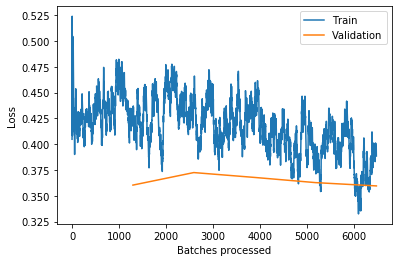

In [68]:
learn.recorder.plot_losses()

In [69]:
learn.save(f'stage-2-512-{arch_name}-{MODEL_NAME}-{DATE}-{UID}')

In [70]:
#learn.fit_one_cycle(5, slice(1e-5, lr/5))

In [71]:
learn.load(f'stage-2-512-{arch_name}-{MODEL_NAME}-{DATE}-{UID}')

Learner(data=ImageDataBunch;

Train: LabelList (20727 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data_02/train/rotated/clipped/padded/reflect/512;

Valid: LabelList (5181 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
healthy_metal,healthy_metal,healthy_metal,healthy_metal,irregular_metal
Path: data_02/train/rotated/clipped/padded/reflect/512;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data_02/train/rotated/clipped/padded/reflect/512, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, st

In [72]:
learn=learn.to_fp32()
learn.export(f'stage-2-512-{arch_name}-{MODEL_NAME}-{DATE}-{UID}.pkl')

### inference

In [73]:
#test_images=data_dir/f'test/rotated/clipped/{img_size}'
test_dataset=ImageList.from_folder(test_images)

In [74]:
len(test_dataset)

14650

In [75]:
learn = load_learner(path=data_dir/f'train/rotated/clipped/{pad_type}/{border}/{img_size}', file=f'stage-2-512-{arch_name}-{MODEL_NAME}-{DATE}-{UID}.pkl', test=test_dataset)

In [76]:
learn.data.loss_func

FlattenedLoss of CrossEntropyLoss()

In [77]:
type(learn.data)

fastai.vision.data.ImageDataBunch

In [78]:
type(learn.dl(DatasetType.Test))

fastai.basic_data.DeviceDataLoader

In [79]:
len(learn.dl(DatasetType.Test))

229

Get number of items in the Valid dataset (in DeviceDataLoader)

In [80]:
preds,y= learn.get_preds(ds_type=DatasetType.Test)

In [81]:
labels = np.argmax(preds, 1)

In [82]:
len(preds)

14650

In [83]:
preds[0].tolist()

[0.04739461839199066,
 0.9187266230583191,
 0.011562017723917961,
 0.013348755426704884,
 0.008968021720647812]

In [84]:
preds_list=[]
for pred in preds:
    preds_list.append(pred.tolist())

In [85]:
len(labels)

14650

In [86]:
learn.data.classes

['concrete_cement', 'healthy_metal', 'incomplete', 'irregular_metal', 'other']

In [87]:
data.classes

['concrete_cement', 'healthy_metal', 'incomplete', 'irregular_metal', 'other']

In [88]:
test_predictions = [learn.data.classes[int(x)] for x in labels]

In [89]:
test_predictions[0]

'healthy_metal'

In [90]:
type(learn.data.test_ds)

fastai.data_block.LabelList

In [91]:
 learn.data.test_ds.x.items

array([PosixPath('data_02/test/rotated/clipped/padded/reflect/512/7a4d9168.tif'),
       PosixPath('data_02/test/rotated/clipped/padded/reflect/512/7a4ae922.tif'),
       PosixPath('data_02/test/rotated/clipped/padded/reflect/512/7a48ca98.tif'),
       PosixPath('data_02/test/rotated/clipped/padded/reflect/512/7a4ba13c_rot90.tif'), ...,
       PosixPath('data_02/test/rotated/clipped/padded/reflect/512/7a501f50.tif'),
       PosixPath('data_02/test/rotated/clipped/padded/reflect/512/7a4cefa6_rot90.tif'),
       PosixPath('data_02/test/rotated/clipped/padded/reflect/512/7a4ce7d6_rot90.tif'),
       PosixPath('data_02/test/rotated/clipped/padded/reflect/512/7a4d27b4.tif')], dtype=object)

In [92]:
ids=[]
for item in learn.data.test_ds.x.items:
    base, id = os.path.split(item)
    id = id.split('.tif')[0]
    ids.append(id)

In [93]:
preds_list[0]

[0.04739461839199066,
 0.9187266230583191,
 0.011562017723917961,
 0.013348755426704884,
 0.008968021720647812]

In [94]:
cols = learn.data.classes.copy()
cols.insert(0,'id')
df = pd.DataFrame(list(zip(ids, preds_list)), 
               columns =['id', 'pred']) 

In [95]:
cols

['id',
 'concrete_cement',
 'healthy_metal',
 'incomplete',
 'irregular_metal',
 'other']

In [96]:
df.head()

,id,pred
0,7a4d9168,"[0.04739461839199066, 0.9187266230583191, 0.01..."
1,7a4ae922,"[0.026205405592918396, 0.9062800407409668, 0.0..."
2,7a48ca98,"[0.006665777415037155, 0.5566691160202026, 0.0..."
3,7a4ba13c_rot90,"[0.012293265201151371, 0.9629964232444763, 0.0..."
4,7a44e752_rot90,"[0.007966429926455021, 0.12052074074745178, 0...."


In [97]:
pred_df = pd.DataFrame(df['pred'].values.tolist())

In [98]:
pred_df.insert(loc=0, column='id', value=ids)

In [99]:
pred_df.columns = cols

In [100]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other
0,7a4d9168,0.047395,0.918727,0.011562,0.013349,0.008968
1,7a4ae922,0.026205,0.906280,0.012713,0.042558,0.012244
2,7a48ca98,0.006666,0.556669,0.009754,0.417856,0.009055
3,7a4ba13c_rot90,0.012293,0.962996,0.006156,0.010885,0.007669
4,7a44e752_rot90,0.007966,0.120521,0.014144,0.847732,0.009637


Required format:
    
<pre>
id	concrete_cement	healthy_metal	incomplete	irregular_metal	other
7a4d630a	0.9	0	0	0	0
7a4bbbd6	0.9	0	0	0	0
7a4ac744	0.9	0	0	0	0
7a4881fa	0.9	0	0	0	0
7a4aa4a8	0.9	0	0	0	0
</pre>


In [101]:
pred_ids=pred_df['id'].values.tolist()

In [102]:
df_baseline = pd.read_csv(data_orig/f'submissions/mean_baseline.csv')

In [103]:
df_baseline.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other
0,7a4d630a,0.093275,0.496369,0.044923,0.352455,0.012979
1,7a4bbbd6,0.093275,0.496369,0.044923,0.352455,0.012979
2,7a4ac744,0.093275,0.496369,0.044923,0.352455,0.012979
3,7a4881fa,0.093275,0.496369,0.044923,0.352455,0.012979
4,7a4aa4a8,0.093275,0.496369,0.044923,0.352455,0.012979


In [104]:
baseline_ids=df_baseline['id'].values.tolist()

In [108]:
len(set(pred_ids))

14650

In [109]:
pred_ids[0:20]

['7a4d9168',
 '7a4ae922',
 '7a48ca98',
 '7a4ba13c_rot90',
 '7a44e752_rot90',
 '7a51936c_rot90',
 '7a49c614',
 '7a4dd4f2',
 '7a4c9664_rot90',
 '7a4bb2d0_rot90',
 '7a45ad18',
 '7a50031c_rot90',
 '7a4af1ba',
 '7a4d2e9e',
 '7a450142_rot90',
 '7a46afec_rot90',
 '7a507590_rot90',
 '7a4e2556_rot90',
 '7a4be8fe_rot90',
 '7a473d54']

In [110]:
 pred_df=pred_df[~pred_df.id.str.contains('_')]

In [111]:
pred_ids=pred_df['id'].values.tolist()

In [107]:
len(baseline_ids)

7325

In [112]:
assert set(pred_ids)==set(baseline_ids)

#### sort by baseline ids

In [113]:
pred_df['id_cat'] = pd.Categorical(
    pred_df['id'], 
    categories=baseline_ids, 
    ordered=True
)

In [114]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other,id_cat
0,7a4d9168,0.047395,0.918727,0.011562,0.013349,0.008968,7a4d9168
1,7a4ae922,0.026205,0.906280,0.012713,0.042558,0.012244,7a4ae922
2,7a48ca98,0.006666,0.556669,0.009754,0.417856,0.009055,7a48ca98
6,7a49c614,0.002208,0.944116,0.002836,0.046273,0.004568,7a49c614
7,7a4dd4f2,0.011993,0.881833,0.012851,0.071157,0.022165,7a4dd4f2


In [115]:
pred_df=pred_df.sort_values('id_cat')

In [116]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other,id_cat
1394,7a4d630a,0.013467,0.938980,0.011009,0.026593,0.009950,7a4d630a
1487,7a4bbbd6,0.008028,0.927863,0.007621,0.047158,0.009329,7a4bbbd6
3622,7a4ac744,0.015653,0.836154,0.012787,0.123143,0.012264,7a4ac744
6758,7a4881fa,0.017798,0.222385,0.017386,0.729142,0.013289,7a4881fa
259,7a4aa4a8,0.009798,0.591652,0.012031,0.369553,0.016966,7a4aa4a8


In [117]:
pred_df.drop(columns=['id_cat'],inplace=True)

In [118]:
pred_df.to_csv(data_orig/f'submissions/stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.csv', index=False)

### Submission 36: 0.5120


In [ ]:
arch_name = 'rn50'
pred_df=pd.read_csv(data_orig/f'submissions/stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.csv')

In [ ]:
pred_df.drop(columns=['id'],inplace=True)
classes=pred_df.idxmax(axis=1)
pd.value_counts(classes).plot(kind="bar")